In [1]:
import gym
import tensorflow as tf
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline
# base code from udacity-deep-learning/reinforcement/Q-learning-cart.ipynb

In [2]:
# Create new cart pole environment
env = gym.make('CartPole-v1')
state = env.reset()
print(state)

[2017-05-22 23:55:00,617] Making new env: CartPole-v1


[-0.00093697 -0.01747059  0.01530989  0.02381758]


In [3]:
# Create class QNetwork
class QNetwork:
    def __init__(self, \
                 learning_rate=0.01, \
                 state_size=4, 
                 action_size=2, \
                 hidden_size=10, \
                 hidden_layers=2, \
                 alpha=0., \
                 name='QNetwork'):
        
        # create Q Network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, \
                                          [None, state_size], \
                                          name='inputs')
            
            # placeholder for actions, to be one-hot encoded next
            self.actions_ = tf.placeholder(tf.int32, \
                                           [None], \
                                           name='actions')
            
            # one hot encode actions
            one_hot_actions = tf.one_hot(self.actions_, \
                                         action_size)
            
            # placeholder for target Qs
            self.targetQs_ = tf.placeholder(tf.float32, \
                                            [None], \
                                            name='target')
            
                
            # ReLU hidden layers
            self.fc1 = tf.layers.dense(self.inputs_, \
                                        hidden_size,\
                                        activation=None,\
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
            self.fc1 = tf.maximum(alpha*self.fc1,self.fc1)
            
            if hidden_layers == 1:
                out_layer = self.fc1
            else:
                
                self.fc2 = tf.layers.dense(self.fc1, hidden_size,\
                                            activation=None,\
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
                self.fc2 = tf.maximum(alpha*self.fc2,self.fc2)
                
                if hidden_layers == 2:
                    out_layer = self.fc2
                else:
                    self.fc3 = tf.layers.dense(self.fc2, hidden_size,\
                                            activation=None,\
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
                    self.fc3 = tf.maximum(alpha*self.fc3,self.fc3)
                    out_layer = self.fc3

            # Linear output layer
            self.output = tf.layers.dense(out_layer, action_size, \
                                          activation=None,\
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [4]:
# create memory class for storing previous experiences
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [6]:
def initialize_memory_rand_states(memory_size=10000,pretrain_length=20):
    # Initialize the simulation
    state = env.reset()
    
    memory = Memory(max_size=memory_size)

    # Make a bunch of random actions and store the experiences
    for ii in range(pretrain_length):

        # Make a random action
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)

        if done:
            # The simulation fails so no next state
            next_state = np.zeros(state.shape)
            # Add experience to memory
            memory.add((state, action, reward, next_state))

            # Start new episode
            state = env.reset()

        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state
            
    return memory

In [20]:
def train_q_network(train_episodes=500,\
                   gamma=0.99,\
                   explore_start=1.0,\
                   explore_stop=0.01,\
                   decay_rate=0.0001,\
                   hidden_size=64,\
                   hidden_layers=2,\
                   learning_rate=0.0001,\
                   memory_size=10000,\
                   batch_size=20,\
                   max_steps=500,\
                   alpha=0.,\
                   verbose=True):
    
    
    mainQN = QNetwork(name='main', hidden_size=hidden_size, hidden_layers=hidden_layers, learning_rate=learning_rate, alpha=alpha)
    
    memory = initialize_memory_rand_states(memory_size=memory_size,pretrain_length=batch_size)

    state = env.reset()
    
    # Now train with experiences
    saver = tf.train.Saver()
    rewards_list = []
    with tf.Session() as sess:
        # Initialize variables
        sess.run(tf.global_variables_initializer())

        step = 0
        steps_list = []
        
        for ep in range(train_episodes):
            total_reward = 0
            t = 0
            
            while t < max_steps:
                step += 1
                # Uncomment this next line to watch the training
                # env.render() 

                # Explore or Exploit
                explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
                if explore_p > np.random.rand():
                    # Make a random action
                    action = env.action_space.sample()
                else:
                    # Get action from Q-network
                    feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                    Qs = sess.run(mainQN.output, feed_dict=feed)
                    action = np.argmax(Qs)

                # Take action, get new state and reward
                next_state, reward, done, _ = env.step(action)

                total_reward += reward

                if done:
                    t = t+1
                    # the episode ends so no next state
                    next_state = np.zeros(state.shape)
                    steps_list.append(t)
                    t = max_steps

                    # Add experience to memory
                    memory.add((state, action, reward, next_state))
                    state = env.reset()
                else:
                    # Add experience to memory
                    memory.add((state, action, reward, next_state))
                    state = next_state
                    t += 1

                # Sample mini-batch from memory
                batch = memory.sample(batch_size)
                states = np.array([each[0] for each in batch])
                actions = np.array([each[1] for each in batch])
                rewards = np.array([each[2] for each in batch])
                next_states = np.array([each[3] for each in batch])

                # Train network
                target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})

                # Set target_Qs to 0 for states where episode ends
                episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
                target_Qs[episode_ends] = (0, 0)

                targets = rewards + gamma * np.max(target_Qs, axis=1)

                loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                    feed_dict={mainQN.inputs_: states,
                                               mainQN.targetQs_: targets,
                                               mainQN.actions_: actions})
            
            rewards_list.append((ep, total_reward))   
            runningMean = np.mean(steps_list[-100:])
            if verbose:
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'RunMean : {:.4f}'.format(runningMean))
               
            
            
            if runningMean > 495.:
                saver.save(sess, "checkpoints/cartpole.ckpt")
                return rewards_list, mainQN, saver
            
        saver.save(sess, "checkpoints/cartpole.ckpt")
        return rewards_list, mainQN, saver

In [13]:
def plot_rewards(rewards_list):
    eps, rews = np.array(rewards_list).T
    smoothed_rews = running_mean(rews, 10)
    plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
    plt.plot(eps, rews, color='grey', alpha=0.3)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

In [14]:
def test_q_network(mainQN, saver, test_episodes=100, test_max_steps=500, render=True):


    avg_rewards = 0.
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
   
        state = env.reset()
        for ep in range(test_episodes):
            t = 0
            while t < test_max_steps:
                if render:
                    env.render() 

                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)

                # Take action, get new state and reward
                next_state, reward, done, _ = env.step(action)
                
                avg_rewards = avg_rewards + reward / test_episodes
                if done:
                    t = test_max_steps
                    state = env.reset()
                    # Take one random step to get the pole and cart moving
                    #state, reward, done, _ = env.step(env.action_space.sample())

                else:
                    state = next_state
                    t += 1
              
    return avg_rewards

In [25]:
def test_and_train_qnetwork(train_episodes=1000,\
                   gamma=0.99,\
                   explore_start=1.0,\
                   explore_stop=0.01,\
                   decay_rate=0.0001,\
                   hidden_size=64,\
                   hidden_layers=2,\
                   learning_rate=0.0001,\
                   memory_size=10000,\
                   batch_size=20,\
                   test_episodes=10,\
                   render=False,\
                   alpha=0.,\
                   verbose=True):
    
    # reset graph
    tf.reset_default_graph()

    # train q-network
    rewards_list, mainQN, saver = train_q_network(train_episodes = train_episodes, \
                                                  gamma=gamma,\
                                                  explore_start=explore_start,\
                                                  explore_stop=explore_stop,\
                                                  decay_rate=decay_rate,\
                                                  hidden_size=hidden_size,\
                                                  hidden_layers=hidden_layers,\
                                                  learning_rate=learning_rate,\
                                                  memory_size=memory_size,\
                                                  batch_size=batch_size,\
                                                  alpha=alpha,\
                                                  verbose=verbose)

    if verbose:
        # plot training
        plot_rewards(rewards_list)
    
    avg_train_rewards = np.sum([each[1] for each in rewards_list]) / len(rewards_list)
    if verbose:
        print('average training reward = ',avg_train_rewards)

    # test q-network
    avg_test_rewards = test_q_network(mainQN, saver, test_episodes=test_episodes, render=verbose)
    if verbose:
        print('average test reward = ', avg_test_rewards)
    
    return avg_test_rewards, avg_train_rewards, mainQN, saver, len(rewards_list)


In [199]:
# test implementation
average_rewards = test_and_train_qnetwork(train_episodes=100, verbose=False)
print('average test reward = ', average_rewards)

INFO:tensorflow:Restoring parameters from checkpoints\cartpole.ckpt


[2017-05-22 15:54:17,537] Restoring parameters from checkpoints\cartpole.ckpt


average test reward =  9.249999999999996


In [28]:
train_eps = 1200
verb = False
gamma = [0.99,0.9]
decay_rate = [0.0001,0.0002]
exp_start=1.0
exp_stop=0.1
hidden_size=[64,128]
hidden_layers=[2,3]
learning_rate=[0.0001,0.00001]
batch_size=[32,64]
num_averages = 1
results = []
alpha_relu = [0.1,0.2]
env = gym.make('CartPole-v1')
env.reset()

for gaIndex in range(len(gamma)):
    for drIndex in range(len(decay_rate)):
        for hs in hidden_size:
            for hl in hidden_layers:
                for lr in learning_rate:
                    for bs in batch_size:
                        for alu in alpha_relu:
                            
                            ga = gamma[gaIndex]
                            dr = decay_rate[drIndex]
                            train_params_name = 'dr='+str(dr)+'_ga='+str(ga)+'_hs='+str(hs)+'_hl'+str(hl)+'_lr'+str(lr)+'_bs'+str(bs)+'_alu='+str(alu)
                            average_test_rewards = 0.
                            average_train_rewards = 0.
                            for i in range(num_averages):
                                test,train, mainQN, saver, num_episodes = test_and_train_qnetwork(memory_size=10000,\
                                                       train_episodes=train_eps,\
                                                       gamma=ga,\
                                                       explore_start=exp_start,\
                                                       explore_stop=exp_stop,\
                                                       decay_rate=dr,\
                                                       hidden_layers=hl,\
                                                       hidden_size=hs,\
                                                       learning_rate=lr,\
                                                       batch_size=bs,\
                                                       alpha = alu,\
                                                       verbose=verb)
                                average_test_rewards += test
                                average_train_rewards += train

                            average_test_rewards = average_test_rewards / num_averages
                            average_train_rewards = average_train_rewards / num_averages
                            results.append([train_params_name+' test='+str(average_test_rewards)+'  numEps='+str(num_episodes)])
                            clear_output()
                            for each in results:
                                print(each)
env.close()

['dr=0.0001_ga=0.99_hs=64_hl2_lr0.0001_bs32_alu=0.1 test=500.0000000000452  numEps=1200']
['dr=0.0001_ga=0.99_hs=64_hl2_lr0.0001_bs32_alu=0.2 test=423.6000000000278  numEps=1200']
['dr=0.0001_ga=0.99_hs=64_hl2_lr0.0001_bs64_alu=0.1 test=9.699999999999982  numEps=1200']
['dr=0.0001_ga=0.99_hs=64_hl2_lr0.0001_bs64_alu=0.2 test=500.0000000000452  numEps=704']
['dr=0.0001_ga=0.99_hs=64_hl2_lr1e-05_bs32_alu=0.1 test=9.299999999999983  numEps=1200']
['dr=0.0001_ga=0.99_hs=64_hl2_lr1e-05_bs32_alu=0.2 test=9.499999999999982  numEps=1200']
['dr=0.0001_ga=0.99_hs=64_hl2_lr1e-05_bs64_alu=0.1 test=8.899999999999984  numEps=1200']
['dr=0.0001_ga=0.99_hs=64_hl2_lr1e-05_bs64_alu=0.2 test=9.499999999999982  numEps=1200']
['dr=0.0001_ga=0.99_hs=64_hl3_lr0.0001_bs32_alu=0.1 test=383.6000000000187  numEps=1200']
['dr=0.0001_ga=0.99_hs=64_hl3_lr0.0001_bs32_alu=0.2 test=500.0000000000452  numEps=1200']
['dr=0.0001_ga=0.99_hs=64_hl3_lr0.0001_bs64_alu=0.1 test=500.0000000000452  numEps=1200']
['dr=0.0001_ga=

[2017-05-23 00:16:21,269] Making new env: CartPole-v1


Episode: 0 Total reward: 17.0 Training loss: 1.1656 Explore P: 0.9997 RunMean : 17.0000
Episode: 1 Total reward: 13.0 Training loss: 1.1657 Explore P: 0.9994 RunMean : 15.0000
Episode: 2 Total reward: 21.0 Training loss: 1.1492 Explore P: 0.9990 RunMean : 17.0000
Episode: 3 Total reward: 12.0 Training loss: 1.1934 Explore P: 0.9987 RunMean : 15.7500
Episode: 4 Total reward: 11.0 Training loss: 1.1641 Explore P: 0.9985 RunMean : 14.8000
Episode: 5 Total reward: 59.0 Training loss: 1.6975 Explore P: 0.9973 RunMean : 22.1667
Episode: 6 Total reward: 21.0 Training loss: 1.7549 Explore P: 0.9969 RunMean : 22.0000
Episode: 7 Total reward: 17.0 Training loss: 2.0484 Explore P: 0.9966 RunMean : 21.3750
Episode: 8 Total reward: 43.0 Training loss: 2.1694 Explore P: 0.9957 RunMean : 23.7778
Episode: 9 Total reward: 17.0 Training loss: 2.8160 Explore P: 0.9954 RunMean : 23.1000
Episode: 10 Total reward: 73.0 Training loss: 2.2687 Explore P: 0.9939 RunMean : 27.6364
Episode: 11 Total reward: 16.0 

[2017-05-23 00:28:11,926] Restoring parameters from checkpoints\cartpole.ckpt


average test reward =  500.0000000000452


ValueError: not enough values to unpack (expected 5, got 4)

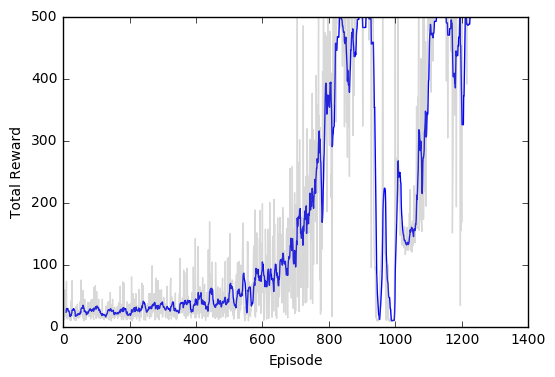

In [21]:
from gym import wrappers
    
env = gym.make('CartPole-v1')
#env = wrappers.Monitor(env, '/tmp/cartpole-experiment-1',force=True)

test,train, mainQN, saver, num_episodes = test_and_train_qnetwork(memory_size=10000,\
                                     train_episodes=4000,\
                                           gamma=0.999,\
                                           explore_start=1.,\
                                           explore_stop=0.0,\
                                           decay_rate=0.00002,\
                                           hidden_layers=1,\
                                           hidden_size=64,\
                                           learning_rate=0.001,\
                                           batch_size=64,\
                                           alpha=0.1,\
                                           verbose=True)
print('test=',str(test))
print(train)
print('number of episodes=',str(num_episodes))
env.close()

In [13]:
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, '/tmp/cartpole-experiment-1',force=True)
avg_test_rewards = test_q_network(mainQN, saver, test_episodes=200, render=False)
print(avg_test_rewards)
env.close
#     if verbose:
#         print('average test reward = ', avg_test_rewards)
    
#     return avg_test_rewards, avg_train_rewards, mainQN, saver

[2017-05-22 23:50:18,379] Making new env: CartPole-v0
[2017-05-22 23:50:18,382] Clearing 4 monitor files from previous run (because force=True was provided)


INFO:tensorflow:Restoring parameters from checkpoints\cartpole.ckpt


[2017-05-22 23:50:18,392] Restoring parameters from checkpoints\cartpole.ckpt
[2017-05-22 23:50:18,484] Starting new video recorder writing to D:\tmp\cartpole-experiment-1\openaigym.video.0.2564.video000000.mp4
[2017-05-22 23:50:21,927] Starting new video recorder writing to D:\tmp\cartpole-experiment-1\openaigym.video.0.2564.video000001.mp4
[2017-05-22 23:50:25,823] Starting new video recorder writing to D:\tmp\cartpole-experiment-1\openaigym.video.0.2564.video000008.mp4
[2017-05-22 23:50:30,765] Starting new video recorder writing to D:\tmp\cartpole-experiment-1\openaigym.video.0.2564.video000027.mp4
[2017-05-22 23:50:37,157] Starting new video recorder writing to D:\tmp\cartpole-experiment-1\openaigym.video.0.2564.video000064.mp4
[2017-05-22 23:50:45,686] Starting new video recorder writing to D:\tmp\cartpole-experiment-1\openaigym.video.0.2564.video000125.mp4


199.9999999998906


<bound method Monitor.close of <Monitor<TimeLimit<CartPoleEnv<CartPole-v0>>>>>

In [15]:
env.close()
gym.upload('/tmp/cartpole-experiment-1', api_key='')

[2017-05-22 23:52:13,462] Finished writing results. You can upload them to the scoreboard via gym.upload('D:\\tmp\\cartpole-experiment-1')
[2017-05-22 23:52:13,463] [CartPole-v0] Uploading 200 episodes of training data
[2017-05-22 23:52:14,715] [CartPole-v0] Uploading videos of 6 training episodes (79922 bytes)
[2017-05-22 23:52:15,216] [CartPole-v0] Creating evaluation object from /tmp/cartpole-experiment-1 with learning curve and training video
[2017-05-22 23:52:15,550] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_XidnJOdDQlK8HQV5xk1QRA

****************************************************


In [2]:
import gym
from gym import wrappers
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, '/tmp/cartpolev1-experiment-1',force=True)
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

[2017-05-22 21:43:41,579] Making new env: CartPole-v0
[2017-05-22 21:43:41,580] Clearing 3 monitor files from previous run (because force=True was provided)
[2017-05-22 21:43:41,585] Starting new video recorder writing to D:\tmp\cartpole-experiment-2\openaigym.video.0.2340.video000000.mp4


[-0.03158918  0.01501189 -0.04439814  0.02392597]
[-0.03128894 -0.17944616 -0.04391962  0.30227684]
[-0.03487786  0.01627333 -0.03787408 -0.00392752]
[-0.0345524   0.21191741 -0.03795263 -0.3083155 ]
[-0.03031405  0.0173562  -0.04411894 -0.02783925]
[-0.02996692  0.21308217 -0.04467573 -0.33410928]
[-0.02570528  0.40881056 -0.05135791 -0.64053921]
[-0.01752907  0.60460946 -0.0641687  -0.9489429 ]


[2017-05-22 21:43:43,488] Starting new video recorder writing to D:\tmp\cartpole-experiment-2\openaigym.video.0.2340.video000001.mp4


[-0.00543688  0.80053387 -0.08314756 -1.26107733]
[ 0.0105738   0.99661498 -0.1083691  -1.57860008]
[ 0.0305061   1.19284804 -0.1399411  -1.90302116]
[ 0.05436306  1.38917853 -0.17800153 -2.2356465 ]
Episode finished after 12 timesteps
[ 0.01721082 -0.01583853 -0.02459659  0.00499927]
[ 0.01689405 -0.21059925 -0.02449661  0.28982131]
[ 0.01268206 -0.01513671 -0.01870018 -0.01048581]
[ 0.01237933 -0.20998555 -0.0189099   0.27623882]
[ 0.00817962 -0.40483268 -0.01338512  0.56289808]
[  8.29628614e-05  -5.99764277e-01  -2.12716057e-03   8.51334169e-01]
[-0.01191232 -0.79485716  0.01489952  1.14334745]
[-0.02780947 -0.99017059  0.03776647  1.44066537]
[-0.04761288 -0.7955336   0.06657978  1.16001877]
[-0.06352355 -0.99145678  0.08978015  1.47281241]
[-0.08335269 -0.79753982  0.1192364   1.2094684 ]
[-0.09930348 -0.60414221  0.14342577  0.95640423]
[-0.11138633 -0.80087136  0.16255386  1.29049072]
[-0.12740375 -0.99764366  0.18836367  1.6293388 ]
Episode finished after 14 timesteps
[ 0.0056

[2017-05-22 21:43:46,601] Starting new video recorder writing to D:\tmp\cartpole-experiment-2\openaigym.video.0.2340.video000008.mp4


[-0.08616021 -0.61744012  0.12611698  1.21169691]
[-0.09850901 -0.42415134  0.15035092  0.96104664]
[-0.10699204 -0.62093918  0.16957185  1.29693513]
[-0.11941082 -0.42832723  0.19551055  1.06177668]
Episode finished after 23 timesteps
[ 0.01929627 -0.04759821  0.01128067 -0.03405203]
[ 0.0183443   0.14736017  0.01059963 -0.32315455]
[ 0.02129151 -0.0479111   0.00413654 -0.02714787]
[ 0.02033328 -0.24309212  0.00359359  0.26683731]
[ 0.01547144 -0.43826518  0.00893033  0.56065151]
[ 0.00670614 -0.63351132  0.02014336  0.85613453]
[-0.00596409 -0.82890187  0.03726605  1.15508265]
[-0.02254213 -0.63428515  0.06036771  0.87431393]
[-0.03522783 -0.83017359  0.07785398  1.18534868]
[-0.0518313  -1.0262142   0.10156096  1.50138481]
[-0.07235558 -0.83246154  0.13158865  1.24206102]
[-0.08900482 -1.02900389  0.15642987  1.57290131]
[-0.10958489 -1.22560767  0.1878879   1.91000915]
Episode finished after 13 timesteps
[-0.02936307  0.04969574  0.03889237  0.02069656]
[-0.02836916  0.24423898  0.